## 生成对抗网络GAN

In [1]:
import torch
from torch import nn
from torch.autograd import Variable

import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



### 可视化

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 


### 数据处理

In [3]:
def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

### 数据加载

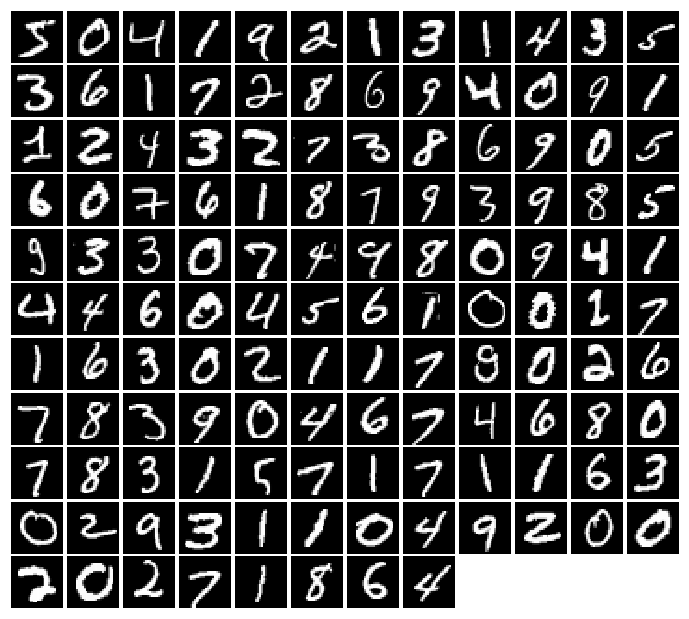

In [4]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

train_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

val_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

val_data = DataLoader(val_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs)


### 生成对抗网络

In [5]:
def discriminator():
    net = nn.Sequential(        
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    return net
def generator(noise_dim=NOISE_DIM):   
    net = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 1024),
        nn.ReLU(True),
        nn.Linear(1024, 784),
        nn.Tanh()
    )
    return net


### Loss 定义

In [7]:
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(logits_real, logits_fake): # 判别器的 loss
    size = logits_real.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    false_labels = Variable(torch.zeros(size, 1)).float().cuda()
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, 
    false_labels)
    return loss

def generator_loss(logits_fake): # 生成器的 loss  
    size = logits_fake.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    loss = bce_loss(logits_fake, true_labels)
    return loss


### Optim 使用Adam

In [8]:
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer


### 训练过程

In [15]:
G_losses = []
D_losses = []

def train_a_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, noise_size=96, num_epochs=50):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络
            real_data = Variable(x).view(bs, -1).cuda() # 真实数据
            logits_real = D_net(real_data) # 判别网络得分
            # -1 ~ 1 的均匀分布
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分
            # 判别器的 loss
            d_total_error = discriminator_loss(logits_real, logits_fake) 
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络
            
            D_losses.append(d_total_error.data[0])
            G_losses.append(g_error.data[0])
            
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data[0], g_error.data[0]))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

/home/blueberry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/blueberry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/blueberry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter: 0, D: 1.373, G:0.6728


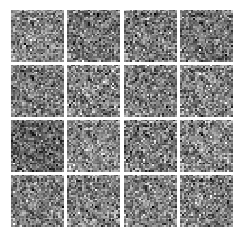


Iter: 250, D: 1.385, G:0.9017


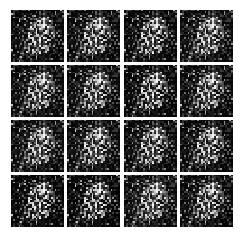


Iter: 500, D: 0.7997, G:1.677


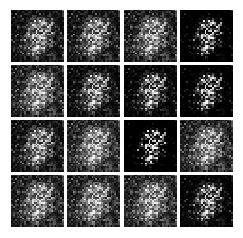


Iter: 750, D: 1.152, G:1.067


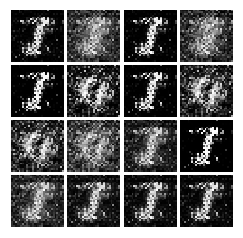


Iter: 1000, D: 0.7536, G:1.327


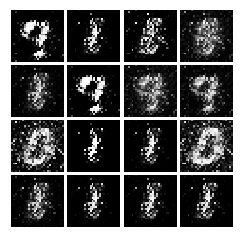


Iter: 1250, D: 0.8036, G:1.537


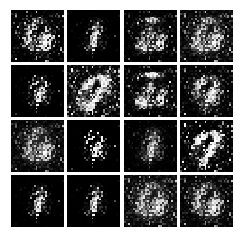


Iter: 1500, D: 0.9785, G:1.485


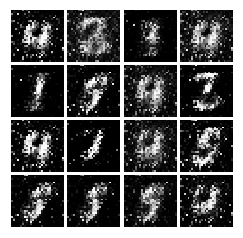


Iter: 1750, D: 1.049, G:0.911


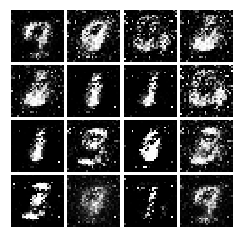


Iter: 2000, D: 1.056, G:2.126


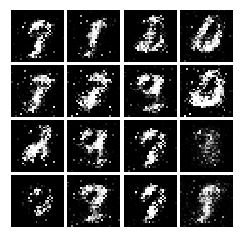


Iter: 2250, D: 0.9431, G:2.552


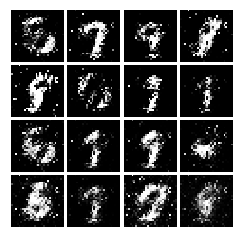


Iter: 2500, D: 0.7705, G:1.539


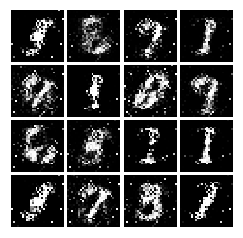


Iter: 2750, D: 1.088, G:1.063


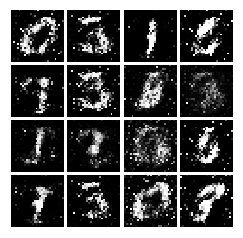


Iter: 3000, D: 1.01, G:2.443


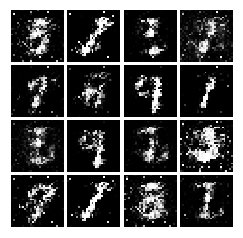


Iter: 3250, D: 1.128, G:0.9689


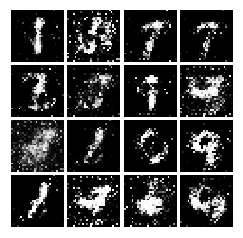


Iter: 3500, D: 0.928, G:2.237


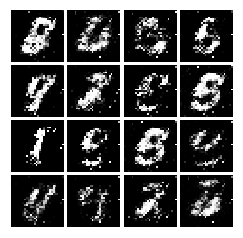


Iter: 3750, D: 0.9652, G:1.323


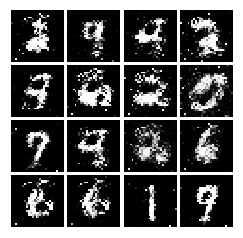


Iter: 4000, D: 1.135, G:1.048


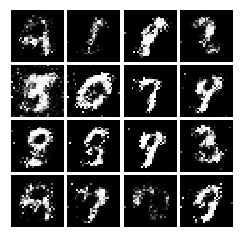


Iter: 4250, D: 1.056, G:1.065


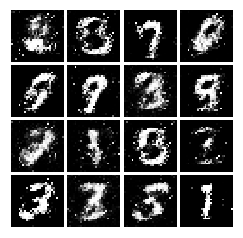


Iter: 4500, D: 1.008, G:1.358


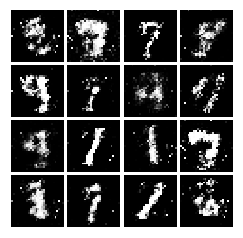


Iter: 4750, D: 1.184, G:0.94


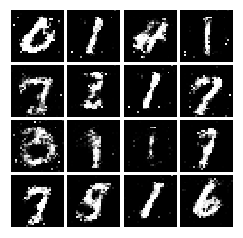


Iter: 5000, D: 1.1, G:1.261


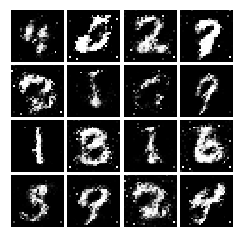


Iter: 5250, D: 1.089, G:1.185


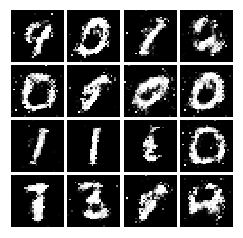


Iter: 5500, D: 1.284, G:1.426


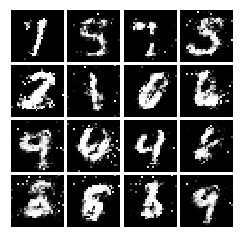


Iter: 5750, D: 1.195, G:0.9994


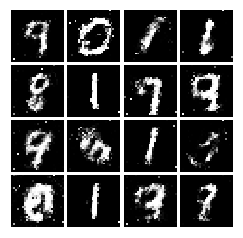


Iter: 6000, D: 1.187, G:0.9604


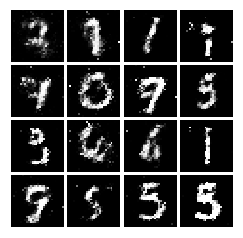


Iter: 6250, D: 1.232, G:1.043


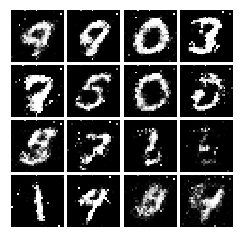


Iter: 6500, D: 1.349, G:0.585


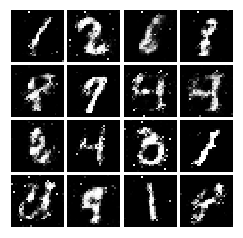


Iter: 6750, D: 1.137, G:1.049


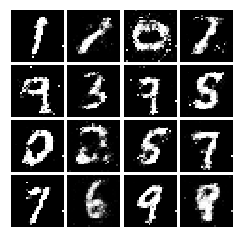


Iter: 7000, D: 1.181, G:0.8275


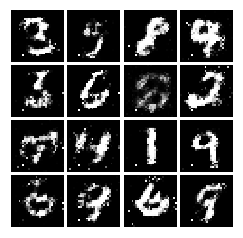


Iter: 7250, D: 1.206, G:1.001


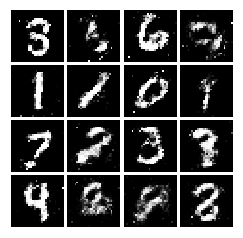


Iter: 7500, D: 1.271, G:1.005


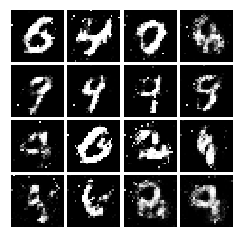


Iter: 7750, D: 1.262, G:0.9265


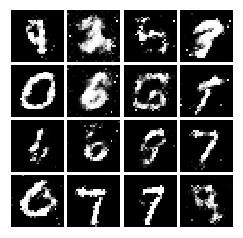


Iter: 8000, D: 1.29, G:0.9961


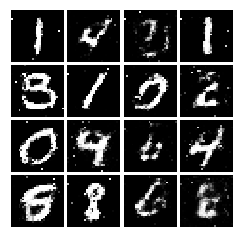


Iter: 8250, D: 1.283, G:0.8932


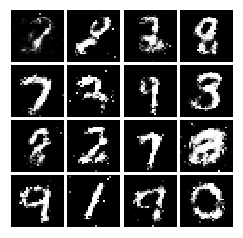


Iter: 8500, D: 1.173, G:0.8822


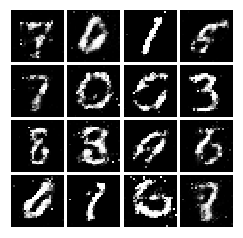


Iter: 8750, D: 1.296, G:0.894


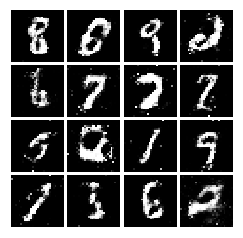


Iter: 9000, D: 1.216, G:0.8469


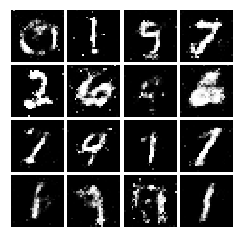


Iter: 9250, D: 1.244, G:0.8476


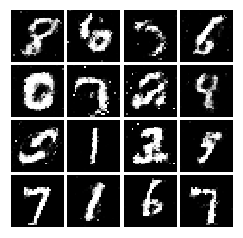


Iter: 9500, D: 1.36, G:0.8357


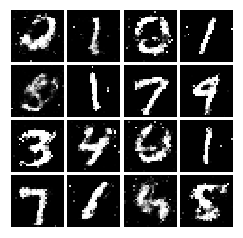


Iter: 9750, D: 1.238, G:0.8646


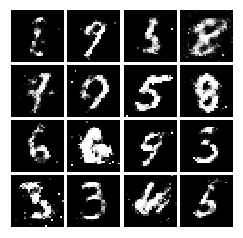


Iter: 10000, D: 1.374, G:0.8217


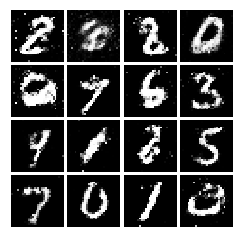


Iter: 10250, D: 1.227, G:0.9625


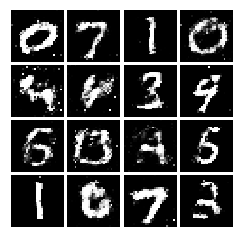


Iter: 10500, D: 1.343, G:0.802


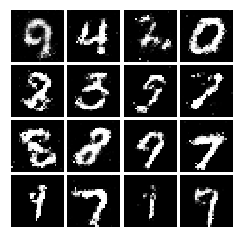


Iter: 10750, D: 1.26, G:0.9113


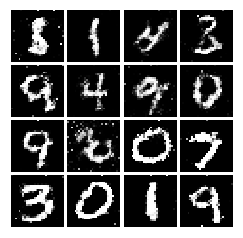


Iter: 11000, D: 1.362, G:0.9035


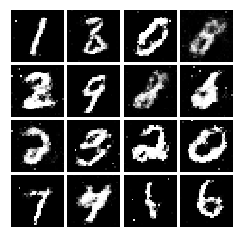


Iter: 11250, D: 1.288, G:0.8425


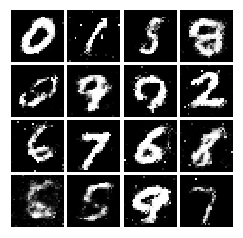


Iter: 11500, D: 1.319, G:0.8703


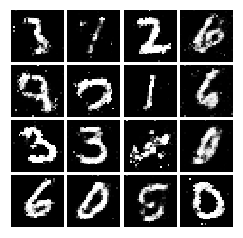


Iter: 11750, D: 1.324, G:0.8258


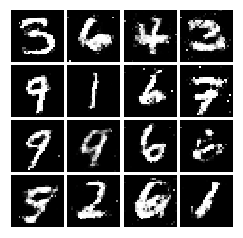


Iter: 12000, D: 1.326, G:0.8327


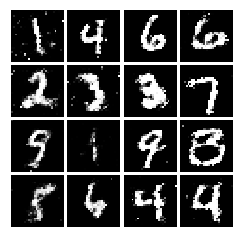


Iter: 12250, D: 1.362, G:0.8694


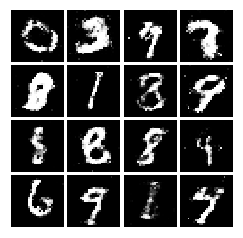


Iter: 12500, D: 1.315, G:0.9126


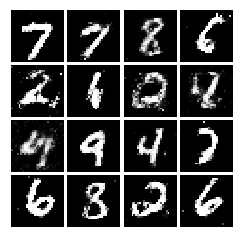


Iter: 12750, D: 1.42, G:0.8591


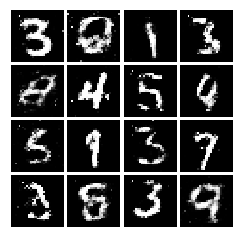


Iter: 13000, D: 1.32, G:0.8924


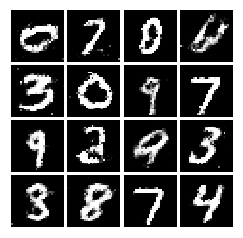


Iter: 13250, D: 1.383, G:0.8064


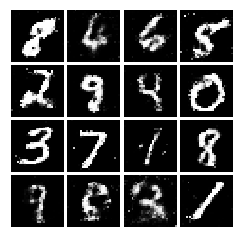


Iter: 13500, D: 1.267, G:0.9456


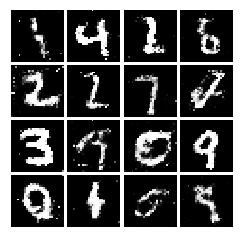


Iter: 13750, D: 1.324, G:0.7621


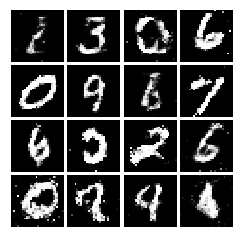


Iter: 14000, D: 1.307, G:0.8312


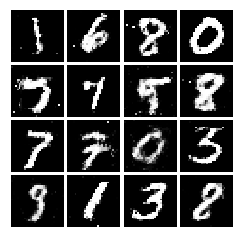


Iter: 14250, D: 1.466, G:0.8333


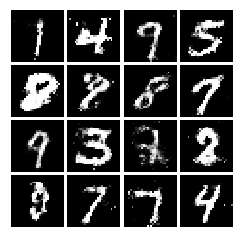


Iter: 14500, D: 1.315, G:0.7958


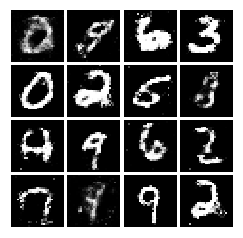


Iter: 14750, D: 1.35, G:0.9575


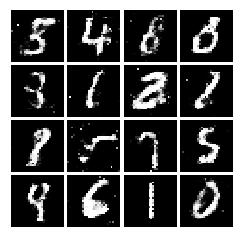


Iter: 15000, D: 1.321, G:0.7963


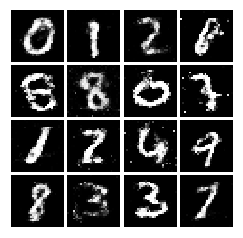


Iter: 15250, D: 1.366, G:0.8773


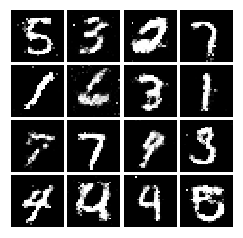


Iter: 15500, D: 1.39, G:0.8979


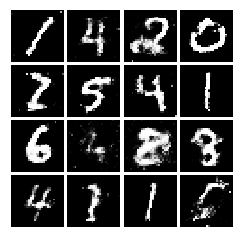


Iter: 15750, D: 1.249, G:0.9056


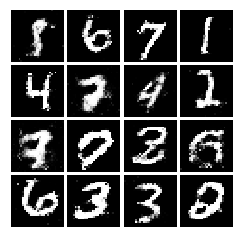


Iter: 16000, D: 1.347, G:0.7216


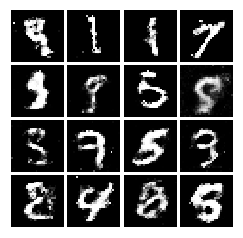


Iter: 16250, D: 1.404, G:0.9439


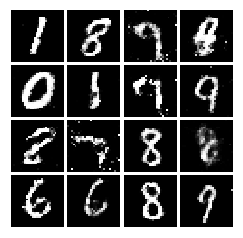


Iter: 16500, D: 1.268, G:0.9259


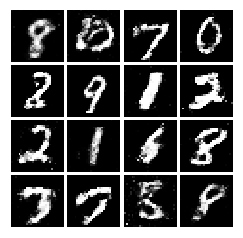


Iter: 16750, D: 1.357, G:0.8549


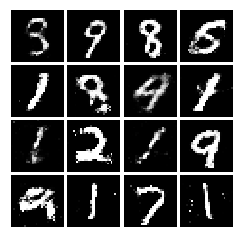


Iter: 17000, D: 1.298, G:0.8802


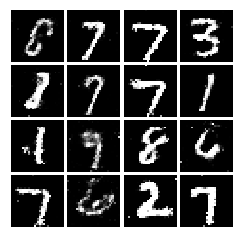


Iter: 17250, D: 1.219, G:0.8987


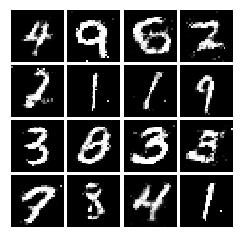


Iter: 17500, D: 1.295, G:0.8349


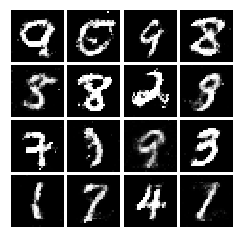


Iter: 17750, D: 1.237, G:0.9385


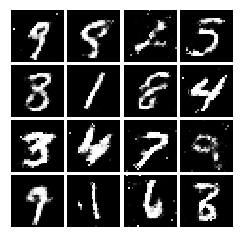


Iter: 18000, D: 1.283, G:0.8964


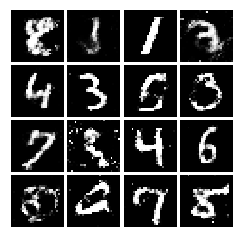


Iter: 18250, D: 1.342, G:0.7874


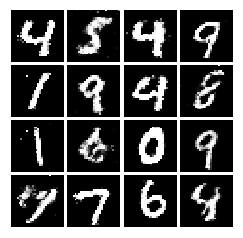


Iter: 18500, D: 1.24, G:0.8609


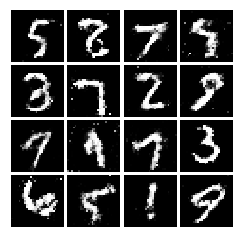


Iter: 18750, D: 1.303, G:0.8412


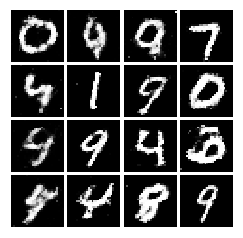


Iter: 19000, D: 1.282, G:0.8145


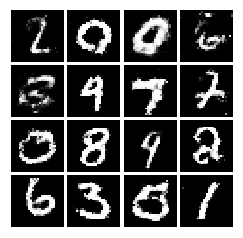


Iter: 19250, D: 1.343, G:0.815


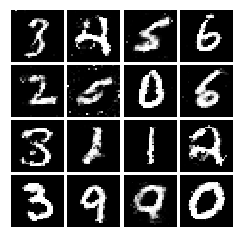


Iter: 19500, D: 1.285, G:0.8934


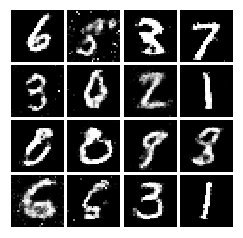

In [16]:
D = discriminator().cuda()
G = generator().cuda()

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_a_gan(D, G, D_optim, G_optim, discriminator_loss, generator_loss)


### Loss 可视化

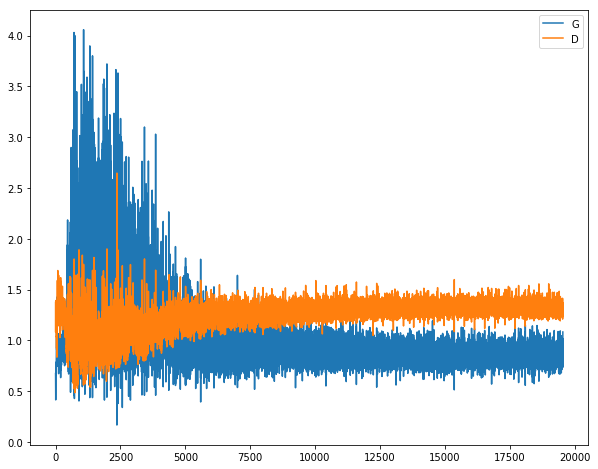

In [17]:
x = np.arange(0,len(G_losses),1)

plt.plot(x,G_losses,"-", label = "G")
plt.plot(x,D_losses,"-", label = "D")

plt.legend()